In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

We use the plummer potential given by (imposing b=1):

$ \Phi=-\frac{GM_{tot}}{(r^2 +a^2)^{1/2}}$

In [ ]:
N=int(1e4)
a = 5
G = 1

#Masses
M_tot = 1
particle_mass = M_tot/N
mass = particle_mass * np.ones(N)

## Functions

In [ ]:
#Potential
potential = lambda m, r, a: - m / ((r**2 + a**2) ** 0.5)

#Density
density = lambda m, a, r : ((3 * m) / (4 * np.pi * a**3)) * (1 + (r/a)**2) ** (-2.5)

#Probability of q
f = lambda q: ((1 - q ** 2) ** 3.5) * q**2

The density goes as

$\rho (r) =\frac{3 M_{tot}}{4\pi a^3}{\big(1+\big({\frac{r}{a}}\big)^2\big)}^{-\frac{5}{2}}$

with a scale parameter.

We find the mass inside a radius r and invert the formula to find r as a function of the radius $\chi=\frac{M}{M_{tot}}$ finding:

$r=\bigg( \frac{\chi^{\frac{2}{3}}}{\big(1-\chi^{\frac{2}{3}}\big)}\bigg)^{\frac{1}{2}}$

In [ ]:
#Sampling r
chi = np.random.uniform(0, 1, N)
r = a * ((chi**(2/3) / (1 - chi**(2/3))) ** 0.5)

### FreeFall Time within a region where r < a

In [ ]:
mask = r < a

#Volume of the scale region within r < a
V = (4/3) * np.pi * a**3

#Density of the scale region within r < a
rho = np.sum(mass[mask])/ V

ff = np.sqrt(3 * np.pi/ (32* G * rho))

print('FreeFall time: {:.3f}'.format(ff))
print('Dynamical time: {:.3f}'.format(3*ff))

## Visualizing the density profile

In [ ]:
plotted = density(M_tot, a, r)

print(np.max(plotted))

plt.scatter(r, plotted, s=3)
plt.xlabel(r'$\frac{r}{a}$')
plt.ylabel(r'$\rho(\frac{r}{a})$')
plt.title('Density')
plt.semilogx();

In [ ]:
#Sampling theta and phi

phi = np.random.uniform(0, 2 * np.pi, N)

arc_theta = np.random.uniform(0, 1, N)
theta = np.arccos(1 - 2 * arc_theta)

In [ ]:
#Visualizing the distributions

plt.hist(r[r<100], bins=100);
plt.title('radius<50')
plt.show()
plt.hist(theta, bins=100);
plt.title('theta')
plt.show()
plt.hist(phi, bins=100);
plt.title('phi')
plt.show()

In [ ]:
#Change of coordinates from spherical to carthesian

x = r * np.sin(theta) * np.cos(phi)

y = r * np.sin(theta) * np.sin(phi)

z = r * np.cos(theta)

In [ ]:
#plotting the generated particles

l = 50

fig = plt.figure(figsize=(10, 10))
fig.suptitle('Positions')
ax = plt.axes(projection='3d')

ax.set(aspect='auto')

#Equal axis length!!
ax.set_box_aspect([1, 1, 1])

ax.scatter3D(x, y, z, color='royalblue', s=2.5 , alpha=.5)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)


plt.show()

We sample valocities using the ratio between the velocity of the particles and the escape velocity given by:

$q=\frac{v}{\sqrt{(2\Psi)}}$

### Rejection method 101
We need to find a function $g(x)$ such that is larger than the pdf $f(x)$ for each $x$, this means we need to differentiate our $F(x)$ but this is very easy since we can just use the fundamental theorem of calculus and find

$$
    f(x) = A q^2 \ \left( 1 - q^2 \right)^{7/2}
$$

After we find a good choice for $g(x)$ we will compute the cumulative and the inverse of the cumulative to obtain some samples $y$ with inverse montecarlo method.

Then we accept only those $y$ such that $y < f(x)$

In [ ]:
qgrid = np.linspace(0, 1, int(1e6))

plt.plot(qgrid, f(qgrid), c='k', lw=3)
plt.title('Theoretical distribution of f(q)')
plt.xlabel(r'$q$')
plt.ylabel(r'$f(q)$');

In [ ]:
from scipy import integrate

#Normalization Constant on f(q)
c_norm = integrate.quad(f, 0, 1)[0]
print('Normalization Constant is: {:.4f}'.format(c_norm))

norm_f = lambda q: (1/c_norm) * ((1 - q ** 2) ** 3.5) * q**2

In [ ]:
#Rejection sampling for q
good_points = []
ybest = np.max(norm_f(qgrid)) + 0.1 #Since Uniform Distribution is exclusive on the high value, we give it a bit of play on y

while(len(good_points) < N):
    q_prop = np.random.uniform(0, 1, 1)
    y_prop = np.random.uniform(0, ybest, 1)
    if (y_prop <= norm_f(q_prop)):
        good_points.append(q_prop)

q = np.array(good_points).flatten()

In [ ]:
np.mean(q)

In [ ]:
q.shape

In [ ]:
#Plotting the distribution of q
plt.hist(q, bins=100, density=True)

plt.plot(qgrid, norm_f(qgrid), c='k', lw=3)
plt.xlabel(r'$q$')
plt.ylabel(r'normalized $f(q)$');

In [ ]:
psi = -potential(M_tot, r, a)

print(np.max(psi))
plt.scatter(r, psi, color='royalblue', s=5 , alpha=.8)
plt.xlim(0, 100)
plt.xlabel(r'$r$')
plt.ylabel(r'$\psi(r)$')
plt.title('Potential');

We sample valocities using the ratio between the velocity of the particles and the escape velocity given by:

$q=\frac{v}{\sqrt{(2\Psi)}}$

In [ ]:
#creating velocities with random direction -> Re-sampling also theta and phi!

v_phi = np.random.uniform(0, 2*np.pi, N)
v_arc_theta = np.random.uniform(0, 1, N)
v_theta = np.arccos(1 - 2 * v_arc_theta)

v = q * ((2 * psi) ** 0.5)

print(np.mean(v))

vx = v * np.sin(v_theta) * np.cos(v_phi)
vy = v * np.sin(v_theta) * np.sin(v_phi)
vz = v * np.cos(v_theta)

In [ ]:
#plotting the generated velocities

lv = 1

fig = plt.figure(figsize=(10, 10))
fig.suptitle('Velocities')
ax = plt.axes(projection='3d')

ax.set(aspect='auto')

#Equal axis length!!
ax.set_box_aspect([1, 1, 1])

ax.scatter3D(vx, vy, vz, color='red',alpha=0.5, s=2.5)

ax.set_xlabel(r'$vx$')
ax.set_ylabel(r'$vy$')
ax.set_zlabel(r'$vz$')

ax.set_xlim(-lv, lv)
ax.set_ylim(-lv, lv)
ax.set_zlim(-lv, lv)

plt.show()

In [ ]:
vx.shape

In [ ]:
plt.hist(vx,bins=100);

## Center of Mass Velocity

v_cm = np.sum(particle_mass * v) / (M_tot)
v_cm

v_cm = np.sum(particle_mass * v) / (M_tot)

v_cm_x = v_cm * np.sin(theta) * np.cos(phi)
v_cm_y = v_cm * np.sin(theta) * np.sin(phi)
v_cm_z = v_cm * np.cos(theta)

vx_new = vx - v_cm_x
vy_new = vy - v_cm_y
vz_new = vz - v_cm_z


#plotting the generated velocities

l = 1.5

fig = plt.figure()
fig.suptitle('Renormalized Velocities')
ax = plt.axes(projection='3d')

ax.set(aspect='auto')

#Equal axis length!!
ax.set_box_aspect([1, 1, 1])

ax.scatter3D(vx_new, vy_new, vz_new, color='red',alpha=0.5, s=2.5)

ax.set_xlabel(r'$vx$')
ax.set_ylabel(r'$vy$')
ax.set_zlabel(r'$vz$')

ax.set_xlim(-l, l)
ax.set_ylim(-l, l)
ax.set_zlim(-l, l)

In [ ]:
# creating the input file
dim = 3

with open ('in_data.txt', 'w+') as f:
    f.write(str(N) + '\n')
    f.write(f'{dim}' + '\n')
    f.write('0' + '\n')
    for m_i in mass:
        f.write(f'{m_i}' + '\n')
    for i in range(N):
        f.write(f'{x[i]} {y[i]} {z[i]}' + '\n')
    for j in range(N):
        f.write(f'{vx[i]} {vy[i]} {vz[i]}' + '\n')

## Running

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os

In [ ]:
a = 5
dtime = 0.03
theta = 0.1
dtout = dtime
tstop = 15

os.system('../Tree-Code/./treecode in=in_data.txt out=output.txt dtime={} theta={} dtout={} tstop={}'.format(dtime, theta, dtout, tstop));

#a = 1
dtime = 0.05
eps = 0.01
theta = 0.1
dtout = dtime
tstop = 3 * ff
os.system('../Tree-Code/./treecode in=in_data.txt out=output.txt dtime={} eps={} theta={} dtout={} tstop={}'.format(dtime, eps, theta, dtout, tstop));

In [ ]:
with open ('parameters.txt', 'w+') as f:
    f.write('a: ' + str(a) + '\n')
    f.write('ditme: ' + str(dtime) + '\n')
    f.write('theta: ' + str(theta) + '\n')
    f.write('dtout: ' + str(dtout) + '\n')
    f.write('tstop: ' + str(tstop) + '\n')

## Fetching

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os

#config plot
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)
%config InlineBackend.figure_format='retina'

In [3]:
#reading the output file
file = 'output.txt'
lines = pd.read_csv(file, names = list(range(3)), sep = '\s+') # Insert Output filename here
N = int(lines.iloc[0, 0].copy())
s = N*3+3

t = np.array([lines.iloc[2::s,0].copy().dropna()]).flatten()

m = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(3, N+3)])
x = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(N+3, 2*N+3)])
y = np.array([lines.iloc[i::s,1].copy().dropna() for i in range(N+3, 2*N+3)])
z = np.array([lines.iloc[i::s,2].copy().dropna() for i in range(N+3, 2*N+3)])
vx = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(2*N+3, 3*N+3)])
vy = np.array([lines.iloc[i::s,1].copy().dropna() for i in range(2*N+3, 3*N+3)])
vz = np.array([lines.iloc[i::s,2].copy().dropna() for i in range(2*N+3, 3*N+3)])

In [4]:
r = np.sqrt(x**2 + y**2 + z**2)
r.shape

(10000, 9)

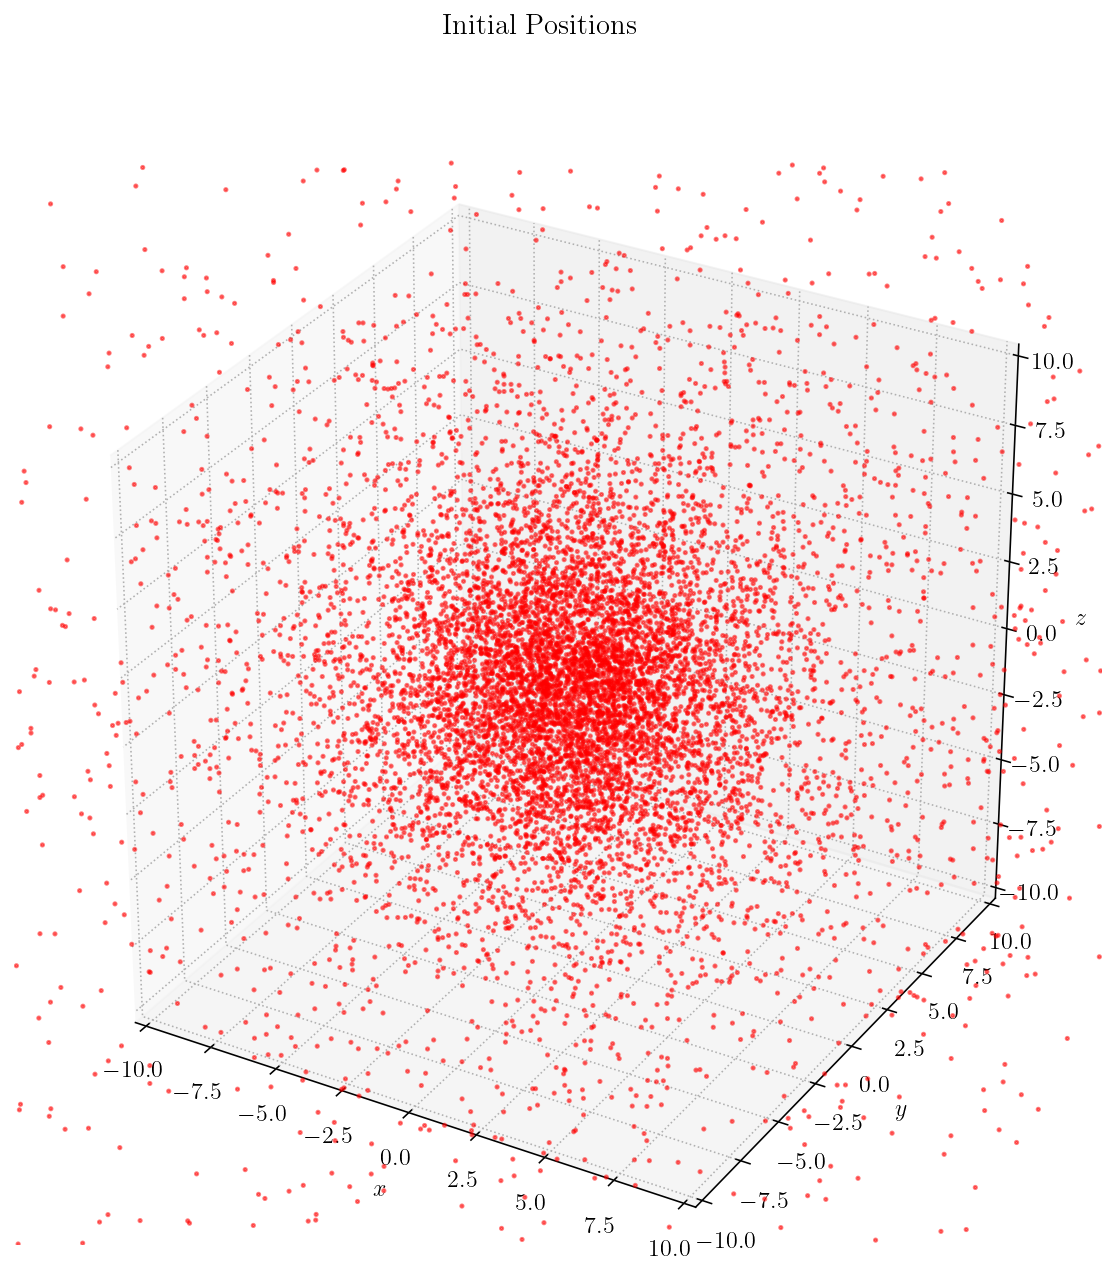

In [5]:
#Plotting the initial positions

l = 10

fig = plt.figure(figsize=(10, 10))
fig.suptitle('Initial Positions')
ax = plt.axes(projection='3d')

ax.set(aspect='auto')

#Equal axis length!!
ax.set_box_aspect([1, 1, 1])

ax.scatter3D(x[:, 0], y[:, 0], z[:, 0], color='red',alpha=0.5, s=2.5)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')

ax.set_xlim(-l, l)
ax.set_ylim(-l, l)
ax.set_zlim(-l, l)


plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

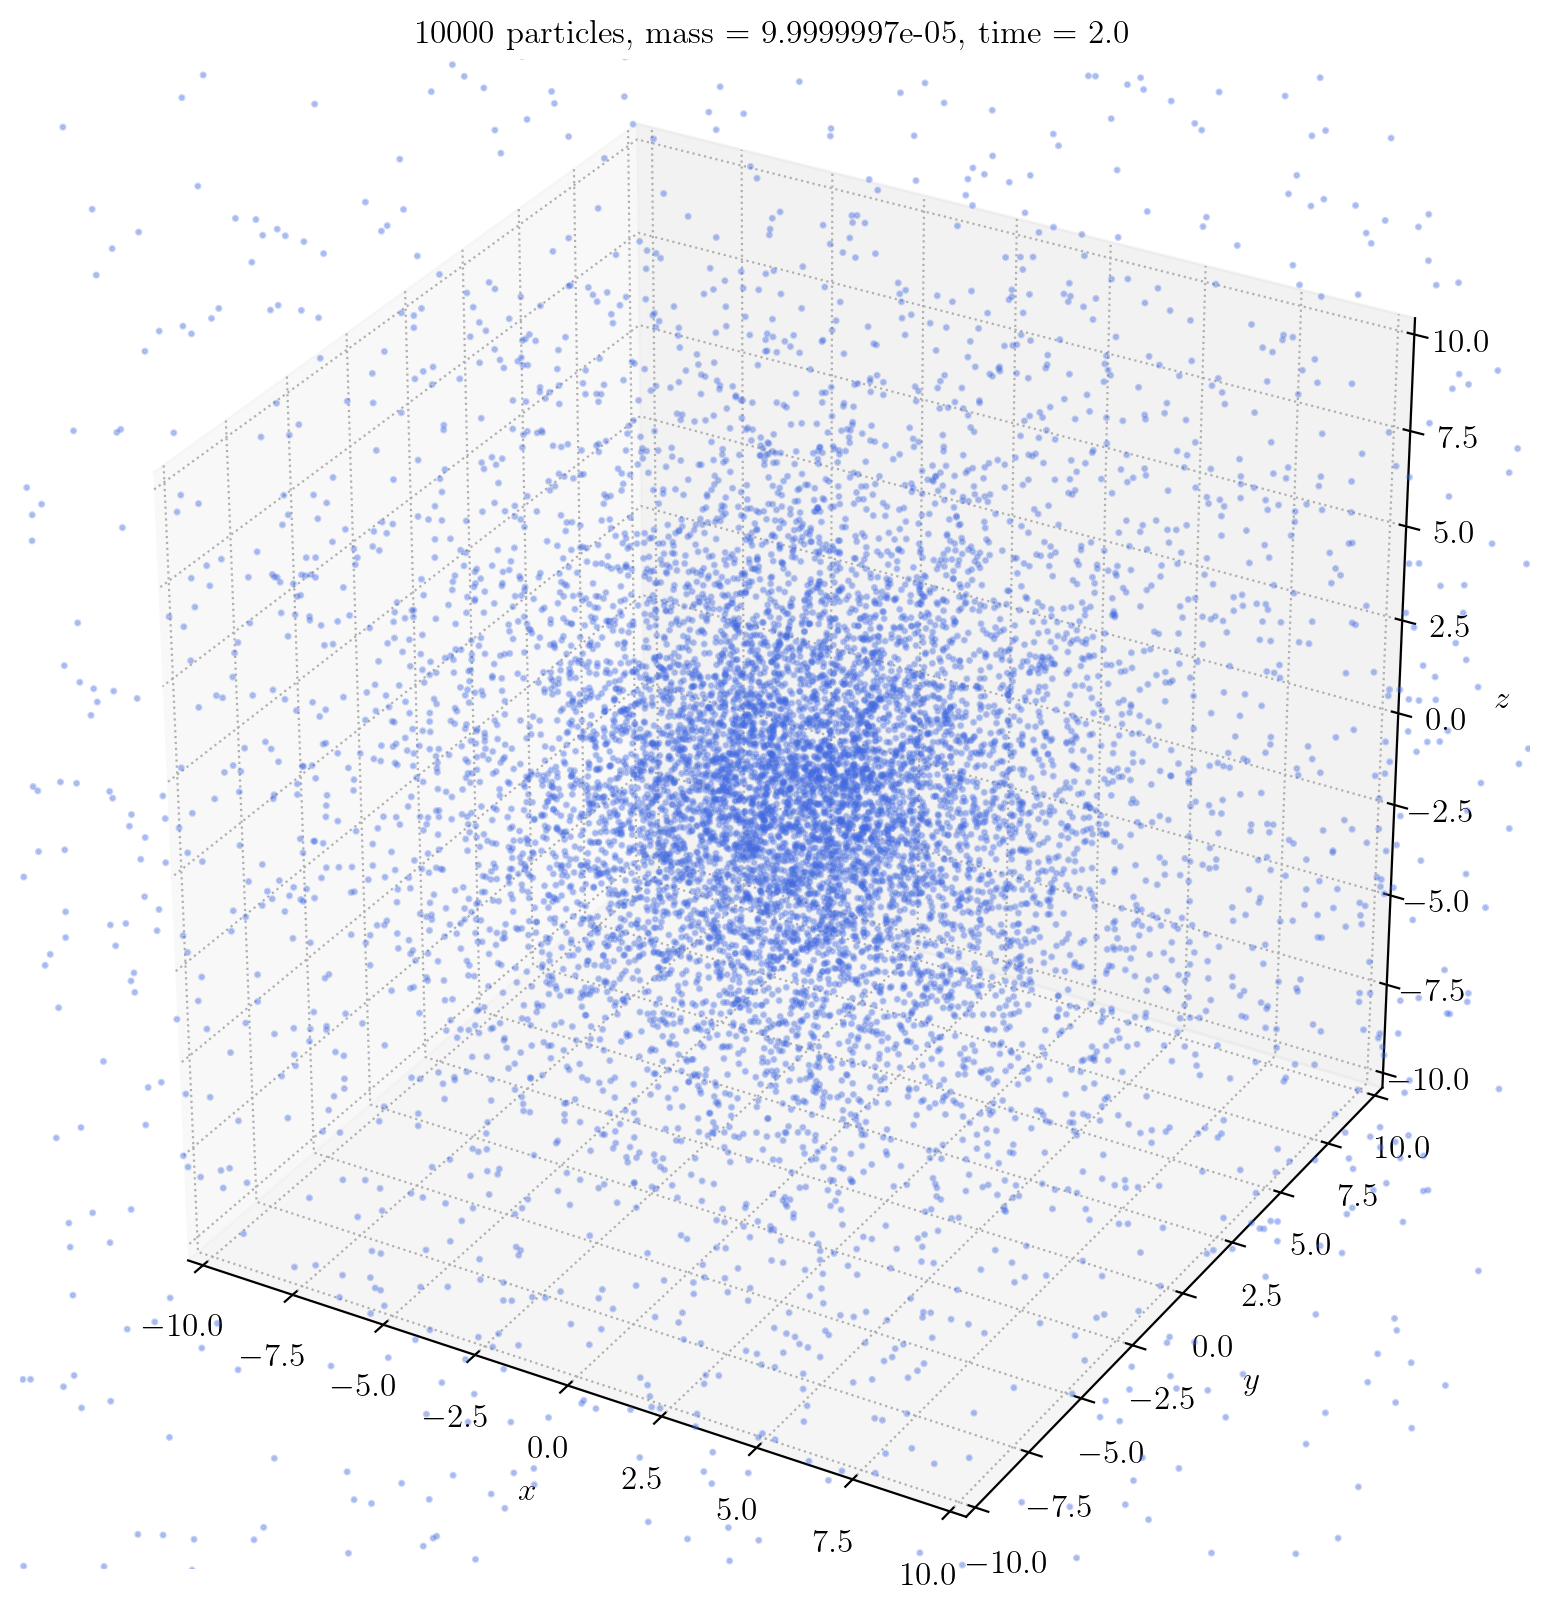

In [6]:
#Animation
from matplotlib import animation

def update(num):
    N = len(m)   #N_particles

    ax.clear()
    
    ax.scatter(x[:, num], y[:, num], z[:, num], color='royalblue', s=2.5 , alpha=.3)        # Updating Point Location

    ax.set_title(f'{N} particles, mass = {m[0,0]}, time = {round(t[num],1)}')

    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$z$')

    ax.set_xlim(-l, l)
    ax.set_ylim(-l, l)
    ax.set_zlim(-l, l)


## Plotting the Animation
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = plt.axes(projection='3d')
ax.set(aspect='auto')

#Equal axis length!!
ax.set_box_aspect([1, 1, 1])

#Axis limit
#l = 10

line_ani = animation.FuncAnimation(fig, 
                                   update, 
                                   interval=1,   
                                   frames=tqdm(range(len(t))),     #For trobuleshooting 100 is ~ 3s, for full movie remember to change it!
                                   cache_frame_data=False)

# Saving the Animation
f = r"zoomed-plummer.gif"
writergif = animation.PillowWriter(fps=30)
line_ani.save(f, writer=writergif)

plt.show()